## Language Complexity through Complex Networks

The metrics extracted from the complex networks respresenting text and pattern recognition methods to analyse complexity in texts.

The correlation is established between language complexity and network topology.

### Intro

Networks represent texts, whose topology is examined through several metrics. The patterns emerging from the topological features are investigated with clustering to correlate with textual complexity.

In [8]:
# imports
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple
%matplotlib inline

In [29]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
from itertools import combinations


def make_edgelist(word_list: List, word_distance: int) -> List[Tuple]:
    """
    Creates edgelist by taking list of words and word_distance. 
    For example, if word_distance is equal to 2, 
    two words are connected if there was at most one intermediate
    word separating them in the preprocessed text.
    """
    edgelist = []
    for i in range(len(word_list)-word_distance):
        subset = word_list[i:i+1+word_distance]
        comb = combinations(subset, 2)
        for apair in comb:
            edgelist.append(apair)
    return edgelist

### Network Formation

In [10]:
demo = nx.Graph()
sent = "yellow fog rub back window pane yellow smoke rub muzzle window pane".split()
demo.add_edges_from(make_edgelist(sent, 2))

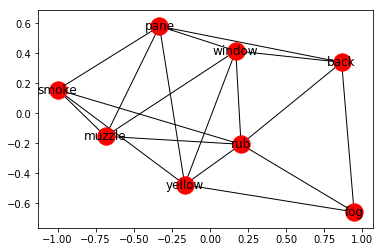

In [11]:
nx.draw_networkx(demo)

#### Pre-processing

In [12]:
import pandas as pd

In [13]:
data = pd.read_csv("data/stories.csv").dropna()

In [14]:
english_data = data[data["story_langugage"] == "English"]

In [15]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [16]:
# have stopword with length more than 1.
stop = [x for x in stop if len(x) > 1]

In [17]:
# adding nbsp and i to stopwords
stop.extend(["nbsp", "i"])

In [19]:
def is_english(text: str) -> bool:
    try:
        text.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [20]:
english_data.head()

Unnamed: 0  story_id                                              title  \
85          155       191                           What Shall I Wear Today?   
108         200       245                                       Rhino Charge   
148         279       360                                 The Auto That Flew   
167         322       415  From Submarines to Sky Raiders - All about Dra...   
218         473       646  The Quirquincho and the Fox - A Folktale from ...   

                                         english_title reading_level_updated  \
85                            What Shall I Wear Today?                    L2   
108                                       Rhino Charge                    L2   
148                                 The Auto That Flew                    L3   
167  From Submarines to Sky Raiders: All About Drag...                    L4   
218  The Quirquincho and the Fox - A Folktale from ...                    L3   

    story_langugage                                           synopsis  \
85          English  On some days, it is so difficult to decide wha...   
108         English  Ringo, a baby rhinoceros lives in the serene g...   
148         English  Caught in the mad traffic of Delhi, an auto fe...   
167         English  Dragonflies have been on the earth much before...   
218         English  A quirquincho and a fox are very good friends ...   

                                               content  \
85   Do you get the feeling sometimes that none of ...   
108  In the grasslands of a National Park called Ka...   
148  Arjun had three wheels, one headlight and a co...   
167  It is one thing to be charged at by a wild ele...   
218  Once upon a time, a fox and a quirquincho (arm...   

                                         category_name  \
85       Fiction, Family & Friends, Read-Aloud Stories   
108                            Fiction, Animal Stories   
148  Fiction, Fantasy, Place & Culture, Read-Aloud ...   
167              Non-fiction, Series, Science & Nature   
218                 Fiction, Series, Folktales & Myths   

                                              tag_name  \
85   What Shall I Wear Today?, dress, clothes, deci...   
108  Rhino Charge, animal, forest, jungle, nature, ...   
148                             auto, transport, Delhi   
167  From Submarines to Sky Raiders, dragonflies, d...   
218  animal stories, folktales, South America, fox,...   

                                  story_original_title  
85                            What Shall I Wear Today?  
108                                       Rhino Charge  
148                                 The Auto That Flew  
167  From Submarines to Sky Raiders - All about Dra...  
218  The Quirquincho and the Fox - A Folktale from ...

In [24]:
import re
# split by punctuations
l1_content = english_data.content.apply(lambda x: re.findall(r"[\w']+|[.,!?;]", str(x).lower()))

In [26]:
# remove punctuations
import string
main_lst = []
for item in l1_content:
  puncs_removed = []
  for i in item:
    i = i.replace('&nbsp', '')
    
    if i and i!='i' and i not in string.punctuation:
      puncs_removed.append(i)
  main_lst.append(puncs_removed)

In [22]:
# removing stopwords
# stopwords_removed = l1_content.apply(lambda x: [item for item in str(x).split() if item not in stop and isEnglish(item)])

In [28]:
# check if word is english and is not a stopword
cleaned = []
for sentence in main_lst:
  english_cleaned = []
  for word in sentence:
    if is_english(word) and word not in stop:
      english_cleaned.append(word)
  cleaned.append(english_cleaned)

In [30]:
# lemmatizing
sentences = []
lemmatized = []
for s in cleaned:
  sentence = " ".join(s)
  sentences.append(sentence)
  doc = nlp(sentence)
  lemm = [token.lemma_ for token in doc]
  lemmatized.append(lemm)

In [31]:
# creating new dataframe
df = pd.DataFrame()

df['lemmatized'] = lemmatized
df['content'] = english_data['content'].tolist()
df['level'] = english_data['reading_level_updated'].tolist()

In [32]:
# this links words whenever they appear immediately adjacent in the pre-processed text
df['edgelist'] = df['lemmatized'].apply(lambda x: make_edgelist(x, 1))

In [33]:
# building graphs for each row of the dataframe
graphs = []
for item in df['edgelist']:
  G = nx.Graph()
  G.add_edges_from(item)
  graphs.append(G)

In [34]:
df['graphs'] = graphs

In [35]:
df['graphs'][0]

### Complex Netwoek metrics

The global measurements are computed using the first two statistical moments of the distribution: 

$$
\mu = n^{-1} \sum\mu(i) 
$$
and

$$
\nabla \mu = n^{-1} \sum (\mu(i) - (\mu))^2
$$

where n is the number if nodes and $\mu(i)$ is the value of metric $\mu$ computed for node $i$.

The metrics to characterize texts are: betweenness (B), clustering coefficent (C) and average shortest path (l).

In [36]:
df['betweenness(B)'] = [nx.betweenness_centrality(graph) for graph in df['graphs']]

In [37]:
df['len_of_lemmatized'] = df['lemmatized'].apply(lambda x: len(x))
df = df.drop(df[df.len_of_lemmatized == 0].index)

In [38]:
df['clustering(C)'] = [nx.clustering(graph) for graph in df['graphs']]

In [39]:
df['avg_shortest_path_length(l)'] = [nx.average_shortest_path_length(graph) for graph in df['graphs']]

In [40]:
df.head()

lemmatized  \
0  [get, feel, sometimes, none, clothe, right, sh...   
1  [grassland, a, national, park, call, kaziranga...   
2  [arjun, three, wheel, one, headlight, a, coat,...   
3  [one, thing, charge, a, wild, elephant, rhino,...   
4  [upon, a, time, a, fox, a, quirquincho, armadi...   

                                             content level  \
0  Do you get the feeling sometimes that none of ...    L2   
1  In the grasslands of a National Park called Ka...    L2   
2  Arjun had three wheels, one headlight and a co...    L3   
3  It is one thing to be charged at by a wild ele...    L4   
4  Once upon a time, a fox and a quirquincho (arm...    L3   

                                            edgelist  \
0  [(get, feel), (feel, sometimes), (sometimes, n...   
1  [(grassland, a), (a, national), (national, par...   
2  [(arjun, three), (three, wheel), (wheel, one),...   
3  [(one, thing), (thing, charge), (charge, a), (...   
4  [(upon, a), (a, time), (time, a), (a, fox), (f...   

                                              graphs  \
0  (seem, mummy, feel, mind, frock, sari, brother...   
1  (feel, middle, elephant, come, kalia, highway,...   
2  (thirst, give, feel, eager, like, see, railway...   
3  (give, sample, non, 500, alert, blood, year, p...   
4  (give, belong, peak, beware, feel, course, lea...   

                                      betweenness(B)  len_of_lemmatized  \
0  {'seem': 0.48385122410546144, 'mummy': 0.03220...                 74   
1  {'afternoon': 0.022746426769250715, 'feel': 0....                403   
2  {'thirst': 0.004967335440336176, 'give': 0.002...                630   
3  {'give': 0.002927661264508459, 'sample': 0.000...               1103   
4  {'give': 0.00011466359833450695, 'belong': 0.0...                593   

                                       clustering(C)  \
0  {'seem': 0, 'mummy': 0, 'feel': 0, 'kurta': 0,...   
1  {'afternoon': 0, 'feel': 0.3333333333333333, '...   
2  {'thirst': 0, 'give': 0, 'feel': 0, 'woman': 0...   
3  {'give': 0.16666666666666666, 'sample': 0, 'no...   
4  {'give': 0, 'belong': 0.2, 'peak': 0, 'feel': ...   

   avg_shortest_path_length(l)  
0                     5.793989  
1                     4.213299  
2                     4.303167  
3                     4.666838  
4                     4.132614

In [43]:
# calculating average and variance for Betweenness and Clustering
avg_btwns = []
avg_C = []
var_btwns = []
var_C = []

for i, row in df.iterrows():
    avg_betw = 1/df['len_of_lemmatized'][i] * sum(df['betweenness(B)'][i].values())
    avg_C_value = 1/df['len_of_lemmatized'][i] * sum(df['clustering(C)'][i].values())
    
    avg_btwns.append(avg_betw)
    avg_C.append(avg_C_value)
    
    diff_betw = [(avg_betw - df['betweenness(B)'][i][x])**2 for x in df['lemmatized'][i]] 
    var_betw = 1/df['len_of_lemmatized'][i] * sum(diff_betw)
    var_btwns.append(var_betw)
    
    diff_avg_clustering = [(avg_C_value - df['clustering(C)'][i][x])**2 for x in df['lemmatized'][i]]
    var_avg_clustering = 1/df['len_of_lemmatized'][i] * sum(diff_avg_clustering)
    var_C.append(var_avg_clustering)

In [44]:
df['avg_btwns'] = avg_btwns

In [45]:
df['var_btwns'] = var_btwns

In [46]:
df['avg_C'] = avg_C
df['var_C'] = var_C

In [47]:
df.head()

lemmatized  \
0  [get, feel, sometimes, none, clothe, right, sh...   
1  [grassland, a, national, park, call, kaziranga...   
2  [arjun, three, wheel, one, headlight, a, coat,...   
3  [one, thing, charge, a, wild, elephant, rhino,...   
4  [upon, a, time, a, fox, a, quirquincho, armadi...   

                                             content level  \
0  Do you get the feeling sometimes that none of ...    L2   
1  In the grasslands of a National Park called Ka...    L2   
2  Arjun had three wheels, one headlight and a co...    L3   
3  It is one thing to be charged at by a wild ele...    L4   
4  Once upon a time, a fox and a quirquincho (arm...    L3   

                                            edgelist  \
0  [(get, feel), (feel, sometimes), (sometimes, n...   
1  [(grassland, a), (a, national), (national, par...   
2  [(arjun, three), (three, wheel), (wheel, one),...   
3  [(one, thing), (thing, charge), (charge, a), (...   
4  [(upon, a), (a, time), (time, a), (a, fox), (f...   

                                              graphs  \
0  (seem, mummy, feel, mind, frock, sari, brother...   
1  (feel, middle, elephant, come, kalia, highway,...   
2  (thirst, give, feel, eager, like, see, railway...   
3  (give, sample, non, 500, alert, blood, year, p...   
4  (give, belong, peak, beware, feel, course, lea...   

                                      betweenness(B)  len_of_lemmatized  \
0  {'seem': 0.48385122410546144, 'mummy': 0.03220...                 74   
1  {'afternoon': 0.022746426769250715, 'feel': 0....                403   
2  {'thirst': 0.004967335440336176, 'give': 0.002...                630   
3  {'give': 0.002927661264508459, 'sample': 0.000...               1103   
4  {'give': 0.00011466359833450695, 'belong': 0.0...                593   

                                       clustering(C)  \
0  {'seem': 0, 'mummy': 0, 'feel': 0, 'kurta': 0,...   
1  {'afternoon': 0, 'feel': 0.3333333333333333, '...   
2  {'thirst': 0, 'give': 0, 'feel': 0, 'woman': 0...   
3  {'give': 0.16666666666666666, 'sample': 0, 'no...   
4  {'give': 0, 'belong': 0.2, 'peak': 0, 'feel': ...   

   avg_shortest_path_length(l)  avg_btwns  var_btwns     avg_C     var_C  
0                     5.793989   0.066980   0.014455  0.000000  0.000000  
1                     4.213299   0.008057   0.007320  0.028726  0.021543  
2                     4.303167   0.005274   0.009945  0.019572  0.015238  
3                     4.666838   0.003335   0.006375  0.022802  0.017382  
4                     4.132614   0.005318   0.008111  0.034333  0.026472

In [48]:
from sklearn.decomposition import PCA
import numpy as np

metrics = df[['avg_btwns', 'var_btwns', 'avg_C', 'var_C', 'avg_shortest_path_length(l)']].copy()
metrics

avg_btwns  var_btwns     avg_C     var_C  avg_shortest_path_length(l)
0     0.066980   0.014455  0.000000  0.000000                     5.793989
1     0.008057   0.007320  0.028726  0.021543                     4.213299
2     0.005274   0.009945  0.019572  0.015238                     4.303167
3     0.003335   0.006375  0.022802  0.017382                     4.666838
4     0.005318   0.008111  0.034333  0.026472                     4.132614
5     0.003727   0.005289  0.030060  0.024161                     4.017298
6     0.004426   0.009857  0.023594  0.015990                     3.916160
7     0.020112   0.014156  0.051823  0.043579                     4.597301
8     0.008565   0.013539  0.037846  0.029860                     4.199131
9     0.007944   0.031249  0.073483  0.067967                     3.679337
10    0.039371   0.034217  0.036217  0.021777                     3.321951
11    0.005052   0.007388  0.044046  0.034794                     4.028733
12    0.007924   0.020766  0.042728  0.035555                     4.000746
13    0.005207   0.009111  0.058076  0.056306                     3.642534
14    0.004543   0.009186  0.040584  0.032147                     4.040496
15    0.004218   0.014696  0.042568  0.038312                     3.594813
16    0.002477   0.003974  0.036007  0.027947                     3.674221
17    0.003240   0.004436  0.040073  0.037906                     4.210444
18    0.006010   0.007275  0.036136  0.028092                     3.816735
19    0.003470   0.006214  0.036014  0.030912                     3.795798
20    0.004330   0.003975  0.027330  0.020628                     4.250896
21    0.003351   0.006019  0.024442  0.016962                     3.898504
22    0.003234   0.006577  0.034995  0.025269                     3.662552
23    0.003611   0.006676  0.031159  0.033192                     3.941922
24    0.007425   0.023006  0.031422  0.024786                     4.271563
25    0.005214   0.002982  0.029924  0.021898                     4.064357
26    0.003003   0.003786  0.028660  0.022409                     4.000344
27    0.018882   0.075792  0.002514  0.000756                     2.939592
28    0.031631   0.041287  0.042913  0.034186                     3.782486
29    0.025332   0.042870  0.064861  0.050694                     3.850746
..         ...        ...       ...       ...                          ...
289   0.017392   0.006098  0.027855  0.027716                     6.303065
290   0.011024   0.028224  0.068066  0.057871                     3.464687
291   0.006282   0.067106  0.063625  0.059869                     3.307031
292   0.008835   0.027372  0.049538  0.038918                     3.598205
293   0.006183   0.016507  0.024597  0.019018                     3.968250
294   0.073732   0.075530  0.047619  0.044086                     3.983957
295   0.011316   0.054540  0.112649  0.087148                     2.765865
296   0.008587   0.010416  0.035488  0.029546                     4.033138
297   0.003781   0.003240  0.033399  0.025892                     3.901562
298   0.032366   0.028512  0.023357  0.020338                     4.137019
299   0.024443   0.031225  0.053171  0.042074                     3.386441
300   0.032554   0.020813  0.038449  0.027979                     4.703052
301   0.023297   0.017894  0.031071  0.024637                     4.038559
302   0.021806   0.005666  0.012237  0.009673                     4.678491
303   0.036118   0.036327  0.030568  0.024641                     5.003130
304   0.019981   0.016261  0.038131  0.024841                     3.385426
305   0.015777   0.018074  0.042569  0.035702                     3.228235
306   0.079104   0.068770  0.044938  0.042236                     4.361905
307   0.027391   0.020700  0.053566  0.051687                     2.833613
308   0.333333   0.222222  0.000000  0.000000                     1.333333
309   0.000000   0.000000  0.000000  0.000000                     1.000000
310   0.070437   0.052561  0.0

### Clustering nodes of Complex Networks

Unsupervised machine learning approach is used to recognize patterns. The objective here is to cluster similar instances, which in our case are instances that belong to a particular _reading level_ are considered similar whenever their complex network measurements took similar values.

The attribute space is formed with metrics from complex networks. The dataset obtained with the attributes are projected onto a two-dimensional space using Principal Component Analysis (PCA).

This reduction in dimentionality could eliminate possible trivial correlations between the metrics.

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(metrics)
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

In [50]:
principal_df['level'] = df['level'].tolist()

In [52]:
principal_df.head()

principal component 1  principal component 2 level
0               1.861921               0.025504    L2
1               0.280847              -0.029947    L2
2               0.370856              -0.033450    L3
3               0.734353              -0.031214    L4
4               0.200005              -0.029997    L3

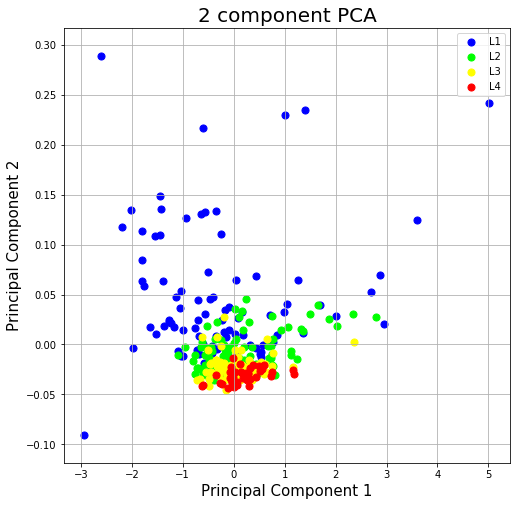

In [53]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['L1', 'L2', 'L3', 'L4']
colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF0000']
for target, color in zip(targets,colors):
    indicesToKeep = principal_df['level'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
               , principal_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [192]:
pca.explained_variance_ratio_

array([0.9938288 , 0.00306167])

With w=2

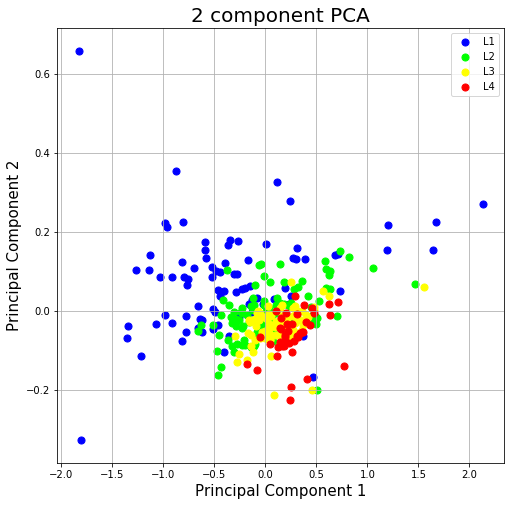

Clusters being formed are better than the one with _w=1_.

## Discussion

The relationship between topology of complex networks and language complexity is studied. The above approach to identify group of texts with the same topological feature in the network, thereby, drawing a parallel between topological features and language complexity. 

We can use Complex Network approach for rapid screening of texts.



Future work:

1. Consider more network metrics to better differentiate the clusters.

2. To examine change in each network metric across _reading levels_.

3. Compare results of the above approach with _linguistic methods_ of calculating language complexity